In [1]:
import os
import dask


import dask.dataframe as dd


# dane, które są przykładowe i nie są dołączone do notebooka
# to dane, które ze zbioru zamowienia.csv zostały sztucznie zwielokrotnione, podzielone i zapisane w kilku
# plikach .csv
ddf = dd.read_csv(os.path.join("zamowienia_expanded.csv"))



In [2]:
ddf


,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
npartitions=24,,,,,
,string,string,string,int64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


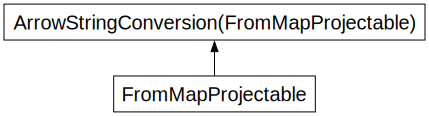

In [3]:
ddf.visualize()


In [4]:


# przed uruchomieniem bieżącej komórki ustaw kartę przeglądarki z dashboardem tak, aby byłą również widoczna
# będzie można śledzić pracę klastra

ddf.head()



,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
0,Niemcy,Peacock,2003-10-29,10337,2467.0
1,Niemcy,Leverling,2004-12-08,10763,616.0
2,Niemcy,Leverling,2004-11-17,10739,240.0
3,Polska,King,2005-01-07,10809,140.0
4,Polska,Kowalski,2003-11-27,10358,429.4


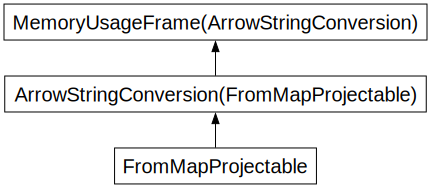

In [5]:
# podobnie jak na zajęciach poprzednich możemy sprawdzić ilość pamięci niezbędnej do przechowania danych ramki
# pamiętajmy o mechanizmie leniwego wywołania, który przygotuje graf obliczeń, ale ich faktycznie jeszcze nie wykona
ddf.memory_usage(deep=True).visualize()


In [6]:
ddm = dd.read_csv(os.path.join("zamowienia_missing.csv"), delimiter=";", assume_missing=True)
ddm.head()
display(ddm.isna().sum().compute())
display(ddm.groupby('Kraj').agg({'Utarg': ['sum', 'mean']}).compute())
ddm.describe().compute()
del ddm


Kraj               0
Sprzedawca         2
Data zamowienia    0
idZamowienia       2
Utarg              1
dtype: int64

Utarg             
              sum         mean
Kraj                          
Polska  333330.91  1550.376326
Niemcy  894496.49  1534.299297

In [7]:
from dask.distributed import Client
import dask.dataframe as dd
import time

client = Client(
    n_workers=4,          # Liczba procesów roboczych
    threads_per_worker=3, # Liczba wątków na proces
    memory_limit="4GB"    # Maksymalna ilość pamięci na proces
)




In [8]:
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 14.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42715,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 14.90 GiB
Comm: tcp://127.0.0.1:35505,Total threads: 3
Dashboard: http://127.0.0.1:43681/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:40885,


In [9]:

import dask.dataframe as dd
ddf = dd.read_parquet('/home/ryba/Documents/Code/snek/bigdata/datasets/instagram/private_instagram/*.parquet', engine='pyarrow')
ddf.head()
ddf.memory_usage(deep=True).compute()


Index                         924
sid                      64252048
sid_profile              64252048
post_id                 152514949
profile_id               64252048
date                    216850662
post_type                64252048
description            1443491245
likes                    64252048
comments                 64252048
username                166198203
bio                     733062367
following                64252048
followers                64252048
num_posts                64252048
is_business_account       8031506
lang                     80315060
category                200053290
dtype: int64

In [10]:
ddf.describe()


,sid,sid_profile,profile_id,post_type,likes,comments,following,followers,num_posts
npartitions=1,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...


In [11]:
ddf.columns


Index(['sid', 'sid_profile', 'post_id', 'profile_id', 'date', 'post_type',
       'description', 'likes', 'comments', 'username', 'bio', 'following',
       'followers', 'num_posts', 'is_business_account', 'lang', 'category'],
      dtype='object')

In [12]:
start_time = time.time()
top_users = ddf.groupby('username')['likes'].sum().nlargest(10).compute()
print("\nTop 10 użytkowników z najwyższą liczbą like'ów:")
print(top_users)

end_time = time.time()
print(f"Czas operacji: {end_time - start_time:.2f} sekund")





Top 10 użytkowników z najwyższą liczbą like'ów:
username
instagram          29864166
lizakoshy          19217644
433                16457870
amandacerny        15019135
akshaykumar        13352324
maisie_williams    12808999
chiaraferragni     11709658
claireholt         10109849
danbilzerian        9253425
urvashirautela      9104884
Name: likes, dtype: int64
Czas operacji: 1.34 sekund


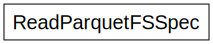

In [13]:
ddf.visualize()


In [14]:
start_time = time.time()

ddf['date'] = dd.to_datetime(ddf['date'])
filtered_ddf = ddf[
        (ddf['date'] >= '2019-01-01') & 
        (ddf['date'] < '2019-07-01')
].persist()
    
print("\nDane za pierwsze półrocze 2019 roku (pierwsze 5 rekordów):")
print(filtered_ddf.head())

end_time = time.time()
print(f"Czas operacji: {end_time - start_time:.2f} sekund")
del filtered_ddf
del ddf



Dane za pierwsze półrocze 2019 roku (pierwsze 5 rekordów):
        sid  sid_profile      post_id  profile_id                date  \
2  28370905      3496776  Bunhd1DFVAG  2237947779 2019-03-05 08:03:11   
4  32170690      3496776  BuDfIyslzfw  2237947779 2019-02-19 08:10:11   
5  14315358      3496776  BxJsMDpA2yH  2237947779 2019-05-07 08:33:51   
6   8304346      3496776  Bt5LFpZlm3z  2237947779 2019-02-15 08:02:35   
7  14315346      3496776  BxZIzaQhS-o  2237947779 2019-05-13 08:32:30   

   post_type                                        description  likes  \
2          1  Tech Tuesday. Been flat out on the tools. Got ...    168   
4          1  Solid effort on the bar turn.\nFully turned.\n...    145   
5          1  Annual springtime flora picture.\nTurn bars in...    124   
6          1  Laps in spring like conditions. Getting these ...    150   
7          1  Cheers Scotland 🏴󠁧󠁢󠁳󠁣󠁴󠁿 See you in a few weeks...    166   

   comments   username                                  

In [15]:
from datetime import datetime
import numpy as np

def count_time(func):
    def wrapper(*args, **kwargs):
        start = datetime.now()
        func(*args, **kwargs)
        print(f"Czas wczytywania {func.__name__}: {datetime.now() - start} sekund")
        return func(*args, **kwargs)
    return wrapper

def sizeof_fmt(num, suffix="B"):
    for unit in ("", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"):
        if np.abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

def describe_size(dataframe):
    output = ''
    tmp = str(sizeof_fmt(sum(dataframe.memory_usage(deep=True).compute())))
    print(tmp)
    output += tmp +'\n'
    for i in dataframe.columns:
        tmp = sizeof_fmt(dataframe[i].memory_usage(deep=True).compute())
        print(i, tmp)
        output += i + ' ' + tmp +'\n'

    return output

def change_dtypes(df, dtype_map: dict):
    for dtype, columns in dtype_map.items():
        if not isinstance(columns, list):
            columns = [columns]

        for column in columns:
            try:
                if dtype == 'timestamp':
                    df[column] = dd.to_datetime(df[column]).astype('int64') // 10**9
                    df[column] = df[column].astype('uint32')
                elif isinstance(dtype, list):
                    success = False
                    for dt in dtype:
                        try:
                            df[column] = df[column].astype(dt)
                            success = True
                            break
                        except Exception as e:
                            pass  # Try the next dtype
                    if not success:
                        print(f"Error converting column '{column}' to any of {dtype}")
                else:
                    # Single dtype, attempt conversion
                    df[column] = df[column].astype(dtype)
            except Exception as e:
                print(f"Error converting column '{column}' to '{dtype}': {e}")
    return df


In [16]:
import dask.dataframe as dd
ddf = dd.read_parquet('/home/ryba/Documents/Code/snek/bigdata/datasets/instagram/private_instagram/*.parquet', engine='pyarrow')
display(ddf.info())
describe_size(ddf)
ddf = change_dtypes(ddf, {
    'category': ['post_type', 'lang', 'username','category', 'bio', 'profile_id'],
    'uint32': ['sid', 'likes', 'comments', 'following', 'followers', 'num_posts'],
    'int32': 'sid_profile',
})
display(ddf.info())
describe_size(ddf)

print()


<class 'dask_expr.DataFrame'>
Columns: 17 entries, sid to category
dtypes: bool(1), int64(9), string(7)

None

3.3GiB
sid 113.8MiB
sid_profile 113.8MiB
post_id 198.0MiB
profile_id 113.8MiB
date 259.3MiB
post_type 113.8MiB
description 1.4GiB
likes 113.8MiB
comments 113.8MiB
username 211.0MiB
bio 751.6MiB
following 113.8MiB
followers 113.8MiB
num_posts 113.8MiB
is_business_account 60.2MiB
lang 129.1MiB
category 243.3MiB
<class 'dask_expr.DataFrame'>
Columns: 17 entries, sid to category
dtypes: category(6), bool(1), int32(1), uint32(6), string(3)

None

2.2GiB
sid 83.2MiB
sid_profile 83.2MiB
post_id 198.0MiB
profile_id 109.2MiB
date 259.3MiB
post_type 60.2MiB
description 1.4GiB
likes 83.2MiB
comments 83.2MiB
username 118.4MiB
bio 163.6MiB
following 83.2MiB
followers 83.2MiB
num_posts 83.2MiB
is_business_account 60.2MiB
lang 60.2MiB
category 60.2MiB



In [17]:
start_time = time.time()
top_users = ddf.groupby('username')['likes'].sum().nlargest(10).compute()
print("\nTop 10 użytkowników z najwyższą liczbą like'ów:")
print(top_users)

end_time = time.time()
print(f"Czas operacji: {end_time - start_time:.2f} sekund")


/home/ryba/Documents/Code/snek/bigdata/.venv/lib/python3.13/site-packages/dask_expr/_groupby.py:1554: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(



Top 10 użytkowników z najwyższą liczbą like'ów:
username
instagram          29864166
lizakoshy          19217644
433                16457870
amandacerny        15019135
akshaykumar        13352324
maisie_williams    12808999
chiaraferragni     11709658
claireholt         10109849
danbilzerian        9253425
urvashirautela      9104884
Name: likes, dtype: uint32
Czas operacji: 3.10 sekund


In [18]:
start_time = time.time()

ddf['date'] = dd.to_datetime(ddf['date'])
filtered_ddf = ddf[
        (ddf['date'] >= '2019-01-01') & 
        (ddf['date'] < '2019-07-01')
].persist()
    
print("\nDane za pierwsze półrocze 2019 roku (pierwsze 5 rekordów):")
print(filtered_ddf.head())

end_time = time.time()
print(f"Czas operacji: {end_time - start_time:.2f} sekund")
del filtered_ddf
del ddf



Dane za pierwsze półrocze 2019 roku (pierwsze 5 rekordów):
        sid  sid_profile      post_id  profile_id                date  \
2  28370905      3496776  Bunhd1DFVAG  2237947779 2019-03-05 08:03:11   
4  32170690      3496776  BuDfIyslzfw  2237947779 2019-02-19 08:10:11   
5  14315358      3496776  BxJsMDpA2yH  2237947779 2019-05-07 08:33:51   
6   8304346      3496776  Bt5LFpZlm3z  2237947779 2019-02-15 08:02:35   
7  14315346      3496776  BxZIzaQhS-o  2237947779 2019-05-13 08:32:30   

  post_type                                        description  likes  \
2         1  Tech Tuesday. Been flat out on the tools. Got ...    168   
4         1  Solid effort on the bar turn.\nFully turned.\n...    145   
5         1  Annual springtime flora picture.\nTurn bars in...    124   
6         1  Laps in spring like conditions. Getting these ...    150   
7         1  Cheers Scotland 🏴󠁧󠁢󠁳󠁣󠁴󠁿 See you in a few weeks...    166   

   comments   username                                        